In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
import wandb
plt.ion()

In [19]:
wandb.init(project="Bayesian DL", name = 'STN_trial', entity="zefko")

wandb: Currently logged in as: zefko (use `wandb login --relogin` to force relogin)


In [17]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 64
}

In [20]:
class MnistRandomPlacement(Dataset):

  def __init__(self, crop_size, digits,mode,download=True):

    self.datasets = []
    self.cropsize = crop_size
    self.download = download
    self.digits = digits
    self.mode = mode

    # False (test) or True (train,val)
    trainingset = self.mode in ['train', 'val']

    self.datasets.append(datasets.MNIST('/content/',
                        transform=transforms.Compose([
                        transforms.ToTensor()]),
                        train=trainingset,
                        download=self.download))

    # self.datasets.append(datasets.KMNIST(opt.dataroot,
    #                     transform=transforms.Compose([
    #                     transforms.ToTensor()]),
    #                     train=trainingset,
    #                     download=opt.download))

    self.num_images = self.digits

  def __len__(self):
    return min([self.datasets[0].__len__() for i in range(self.num_images)])

  def __getitem__(self, idx):

    im = torch.zeros((1, 96, 96), dtype=torch.float)

    used_positions, target = [], ''
    for i in range(self.num_images):
      while True:
        x = np.random.randint(0, 96 - 32)
        if len(used_positions) == 0 or abs(used_positions[0][0] - x) > 32:
          break
      while True:
        y = np.random.randint(0, 96 - 32)
        if len(used_positions) == 0 or abs(used_positions[0][1] - y) > 32:
          break

      im1, target1 = self.datasets[i].__getitem__((idx) * (i + 1) % self.datasets[i].__len__())

      c, w, h = im1.shape

      im[:, y:y + h, x:x + w] = im1.type(torch.float)
      #print('created image', im.shape, 'x:', x, 'y:', y)

      target += str(target1)

      transform = transforms.Compose(
      [transforms.ToPILImage(),transforms.Resize(self.cropsize), transforms.ToTensor(),#, transforms.RandomRotation(degrees=(0,180))
      transforms.Normalize((0.1307,), (0.3081,))])
      im = transform(im)

      

      return im,int(target)

In [21]:
train_mnist = MnistRandomPlacement(28,10,'train',True)
test_mnist = MnistRandomPlacement(28,10,'test',True)

0 torch.Size([1, 28, 28]) 5
1 torch.Size([1, 28, 28]) 0
2 torch.Size([1, 28, 28]) 4
3 torch.Size([1, 28, 28]) 1
4 torch.Size([1, 28, 28]) 9


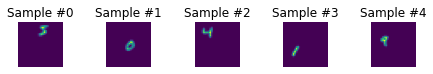

In [34]:
fig = plt.figure()

for i in range(len(train_mnist.datasets[0])):
    image,label = train_mnist[i]

    print(i, image.shape, label)

    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(image[0,:,:].numpy())




    if i == 4:
        plt.show()
        break
wandb.log({'MNIST examples': wandb.Image(ax)})

In [35]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root='.', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])), batch_size=64, shuffle=True, num_workers=4)

# Training dataset random placement
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=2)


# Test dataset
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root='.', train=False, transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])), batch_size=64, shuffle=True, num_workers=4)


# Test dataset random placement mnist
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=64, shuffle=True, num_workers=2)

In [29]:
device

device(type='cuda')

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


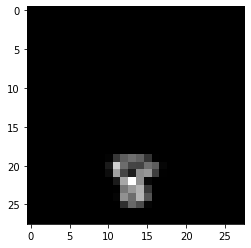

Label: 8


In [36]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [44]:
preview_dt = wandb.Table(columns=["id", "image", "label", "split"])

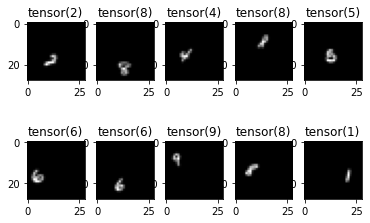

In [53]:
for i in range(10):
    label = train_labels[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(train_features[i][0], cmap='gray')
    plt.title(label)
    #print(f"Label: {label}")
    preview_dt.add_data(i,wandb.Image(train_features[i]),label,'train')
wandb.log({'Train Input':preview_dt})

In [54]:
wandb.finish()

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1805, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1988, in _on_finish
    self._poll_exit_response = self._wait_for_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1935, in _wait_for_finish
    self._on_finish_progress(pusher_stats, done)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1923, in _on_finish_progress
    self._pusher_print_status(progress, done=done)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1899, in _pusher_print_status
    self._jupyter_progress.close()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/ipython.py", line 97, in close
    self._widget.close()
  File "/usr/local/lib/python3.7/dist-packages/ipywidgets/widgets/widget.py", line 469

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        #self.conv3 = nn.Conv2d(20, 30, kernel_size=5)
        #self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) #original
        #self.fc1 = nn.Linear(16820, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

#apply laplace to the last linera layer for the first attempt
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),#original
            #nn.Linear(10 * 28* 28, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        #print('x',x.size())
        xs = self.localization(x)

        #print('xs',xs.size())
        xs = xs.view(-1, 10 * 3 * 3) #original
        #xs = xs.view(-1, 10 * 28 * 28)

        #print('xs view',xs.size())
        theta = self.fc_loc(xs)

        #print('theta before view',theta.shape)
        theta = theta.view(-1, 2, 3)
        #print('theta',theta.shape)
        #print('size',x.size())


        grid = F.affine_grid(theta, x.size(),align_corners =True)
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):

        #print('input',x.size())
        # transform the input
        x = self.stn(x)

        #print('transform',x.size())
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print('forward1',x.size())

        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print('forward2',x.size())

        #x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        #print('forward2+',x.size())

        x = x.view(-1, 320) #original
        #x = x.view(-1, 16820)

        #print('forward3',x.size())

        x = F.relu(self.fc1(x))
        #print('forward4',x.size())

        x = F.dropout(x, training=self.training)
        #print('forward5',x.size())

        x = self.fc2(x)
        #print('forward6',x.size())

        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [47]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [49]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    wandb.watch(model, optimizer,log="all", log_freq=10)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            wandb.log({"epoch": epoch, "loss": loss.item()})
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [50]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        wandb.log({"test loss": test_loss})

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [12]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [51]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 100 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()
wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306885
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.307741


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.




Test set: Average loss: 2.2997, Accuracy: 1439/10000 (14%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.299720
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.300446

Test set: Average loss: 2.2913, Accuracy: 1561/10000 (16%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.287234
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.284089

Test set: Average loss: 2.2578, Accuracy: 1782/10000 (18%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.268181
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.228454

Test set: Average loss: 2.1956, Accuracy: 1947/10000 (19%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.133359
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.169870

Test set: Average loss: 2.1461, Accuracy: 2096/10000 (21%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.171651
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.113768

Test set: Average loss: 2.0961, Accuracy: 2198/10000 (22%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.104756
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.045749

Test set: Average loss: 2.0208, Accuracy: 2375/10000 (24%)

Tra

KeyboardInterrupt: 

In [55]:
wandb.finish()